# **XGBoost Binary Classification: Churn Prediction**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # or any classifier
import warnings
import math
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [ ]:
!pip install feature_engine

## Google Drive: Mounting Google Drive locally

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read from
path = '/content/drive/MyDrive/Colab/Datasets/telco-customer-churn.csv'
# path = '/data/telco-customer-churn.csv' # USE THIS IF LOCAL

df = pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
def data_cleaning(df):
    df = df[df['TotalCharges'] != ' ']
    df['TotalCharges'] = df['TotalCharges'].astype('float')
    df.reset_index(drop=True, inplace=True)
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    return df

df = data_cleaning(df)

# EDA

## Categorical Feature Analysis

Overall target mean: 26.58%


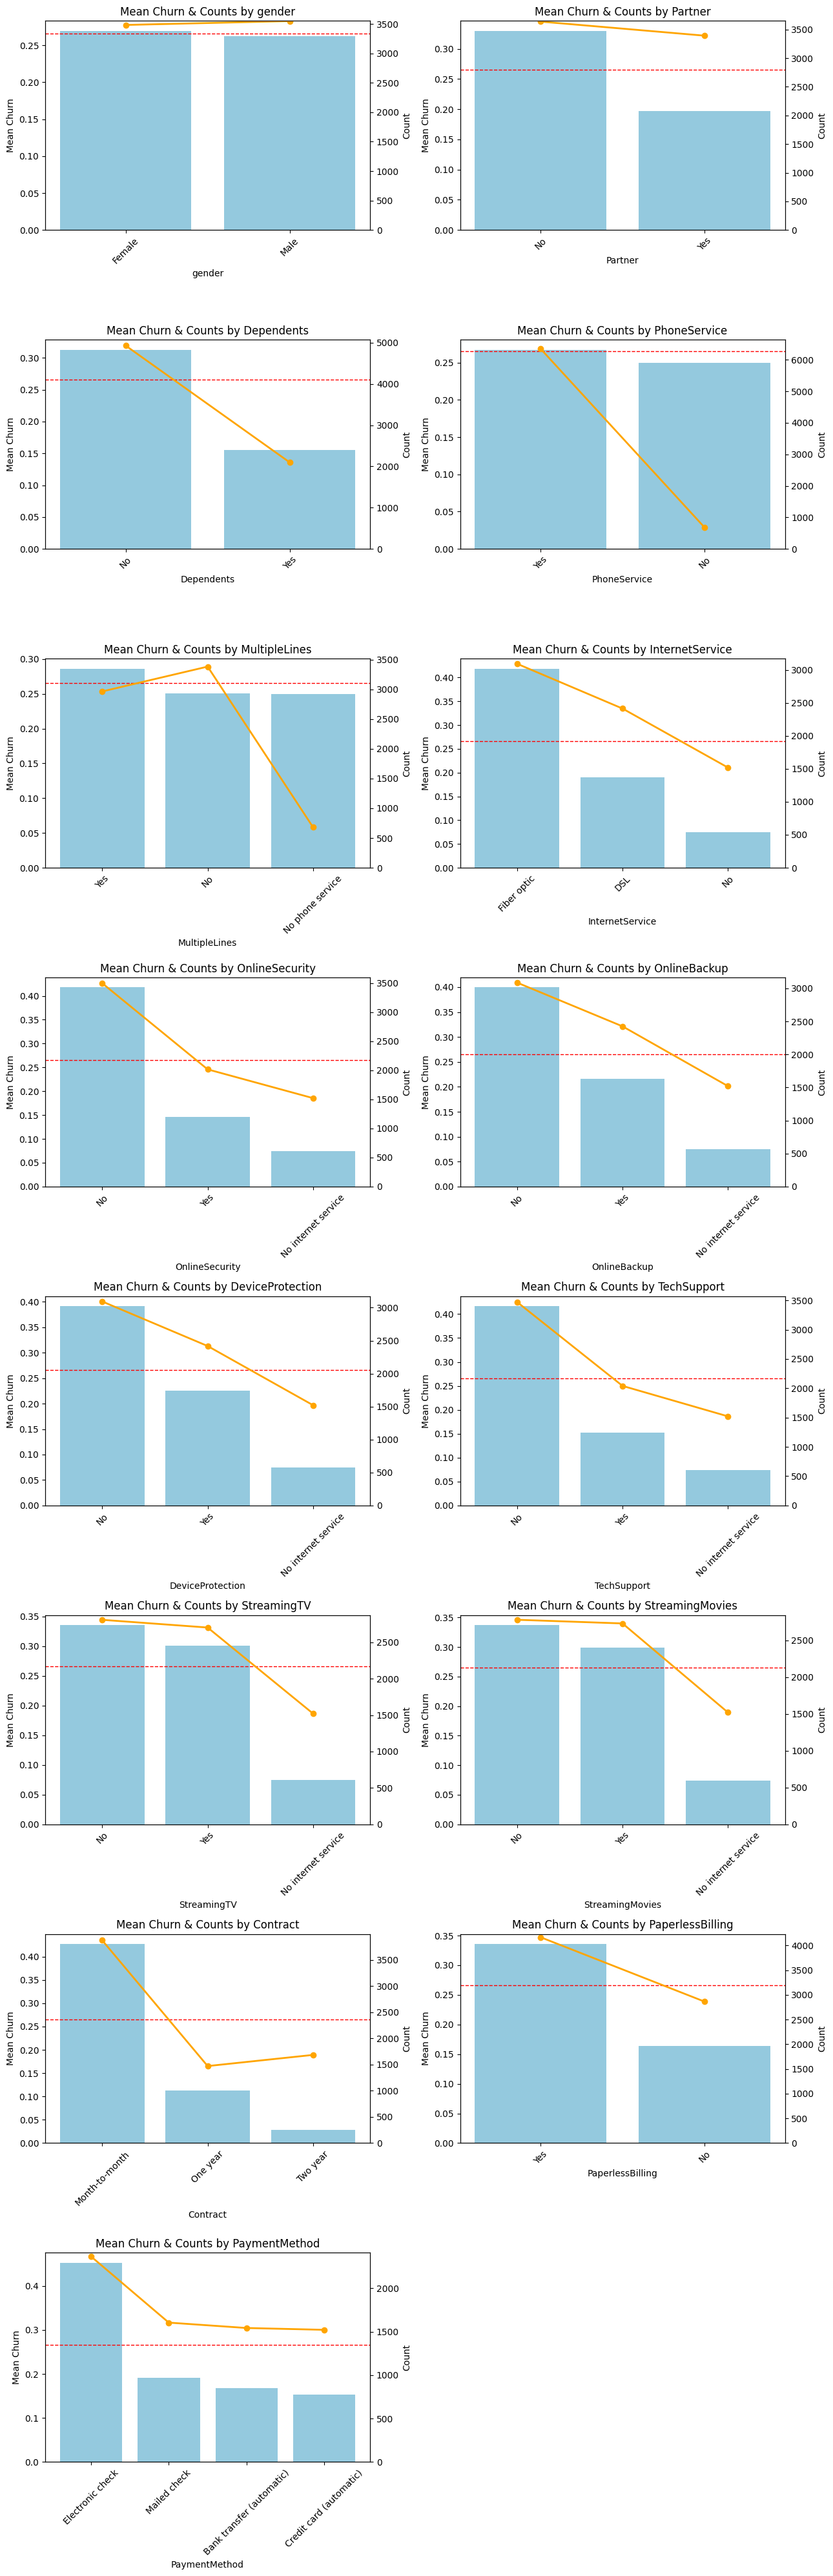

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mean target
target = 'Churn'
mean_target = df[target].mean()
print(f"Overall target mean: {mean_target:.2%}")


# Number of plots and grid shape
cols_to_remove = ['customerID']
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
filtered_cols = [item for item in cat_cols if item not in cols_to_remove]
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Plot mean target and counts across all categorical variables
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6.5, rows * 5))
axes = axes.flatten()

for i, col in enumerate(filtered_cols):
    # Calculate mean target and counts per category
    grouped = df.groupby(col).agg(
        mean_target=(target, 'mean'),
        count=(target, 'size')
    ).reset_index()

    # Sort categories by mean target for clarity
    grouped = grouped.sort_values(by='mean_target', ascending=False)

    # Create primary bar plot for mean target
    sns.barplot(data=grouped, x=col, y='mean_target', ax=axes[i], color="skyblue")

    # Create a secondary Y-axis for counts (line plot)
    ax2 = axes[i].twinx()
    ax2.plot(
        grouped[col],
        grouped['count'],
        color='orange',
        marker='o',
        linewidth=2,
        label='Count'
    )

    # Set secondary Y-axis to start at 0
    ax2.set_ylim(bottom=0)

    # Add reference line for overall mean target on primary Y-axis
    axes[i].axhline(mean_target, color='red', linestyle='--', linewidth=1)

    # Set labels and titles
    axes[i].set_title(f'Mean {target} & Counts by {col}')
    axes[i].set_ylabel(f'Mean {target}')
    axes[i].set_xlabel(col)
    ax2.set_ylabel("Count")

    # Rotate category labels for readability
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

## Numeric Feature Analysis

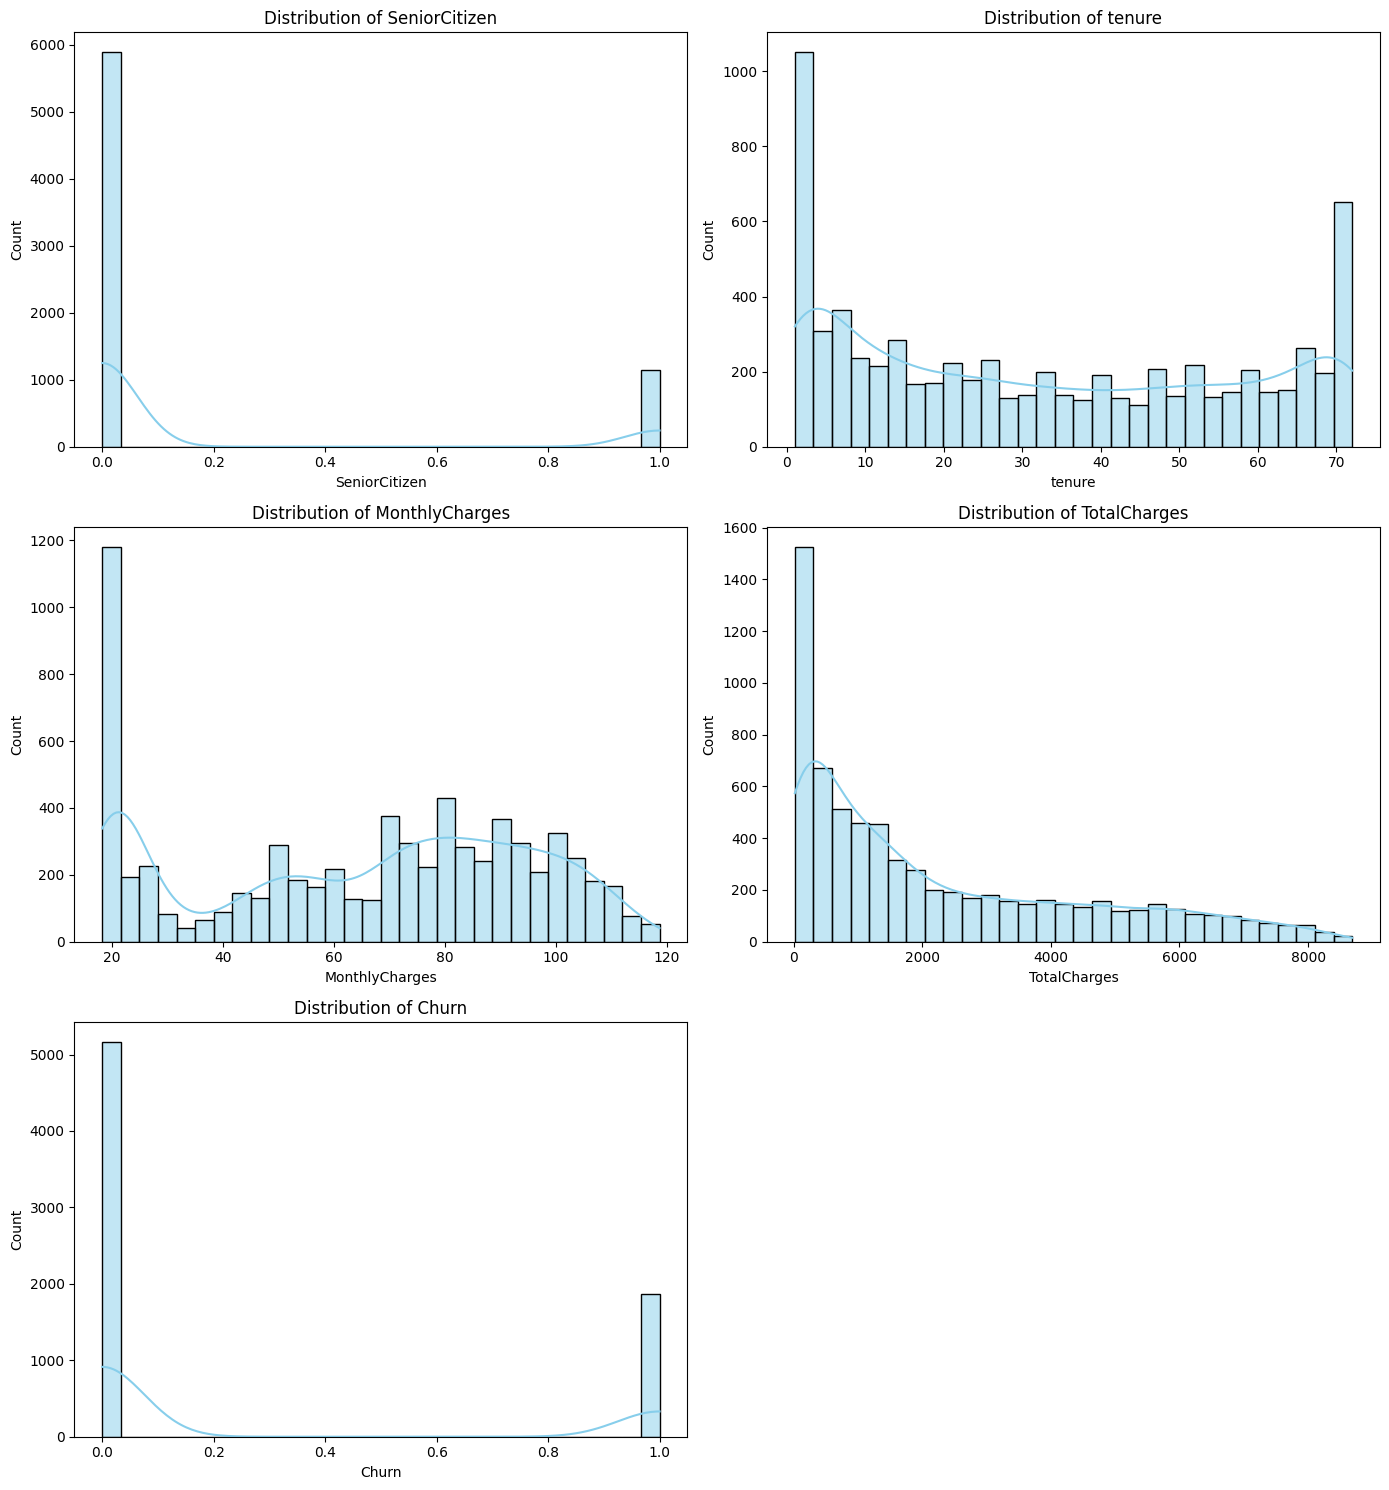

In [ ]:
# # Optional: columns to exclude
# cols_to_remove = ['customerID', 'some_other_column']  # <-- adjust as needed

# Select numeric features
num_cols = df.select_dtypes(include='number').columns.tolist()
filtered_cols = [col for col in num_cols if col not in cols_to_remove]

# Subplot layout
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5))
axes = axes.flatten()

# Plot each numeric feature with KDE
for i, col in enumerate(filtered_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(col)

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

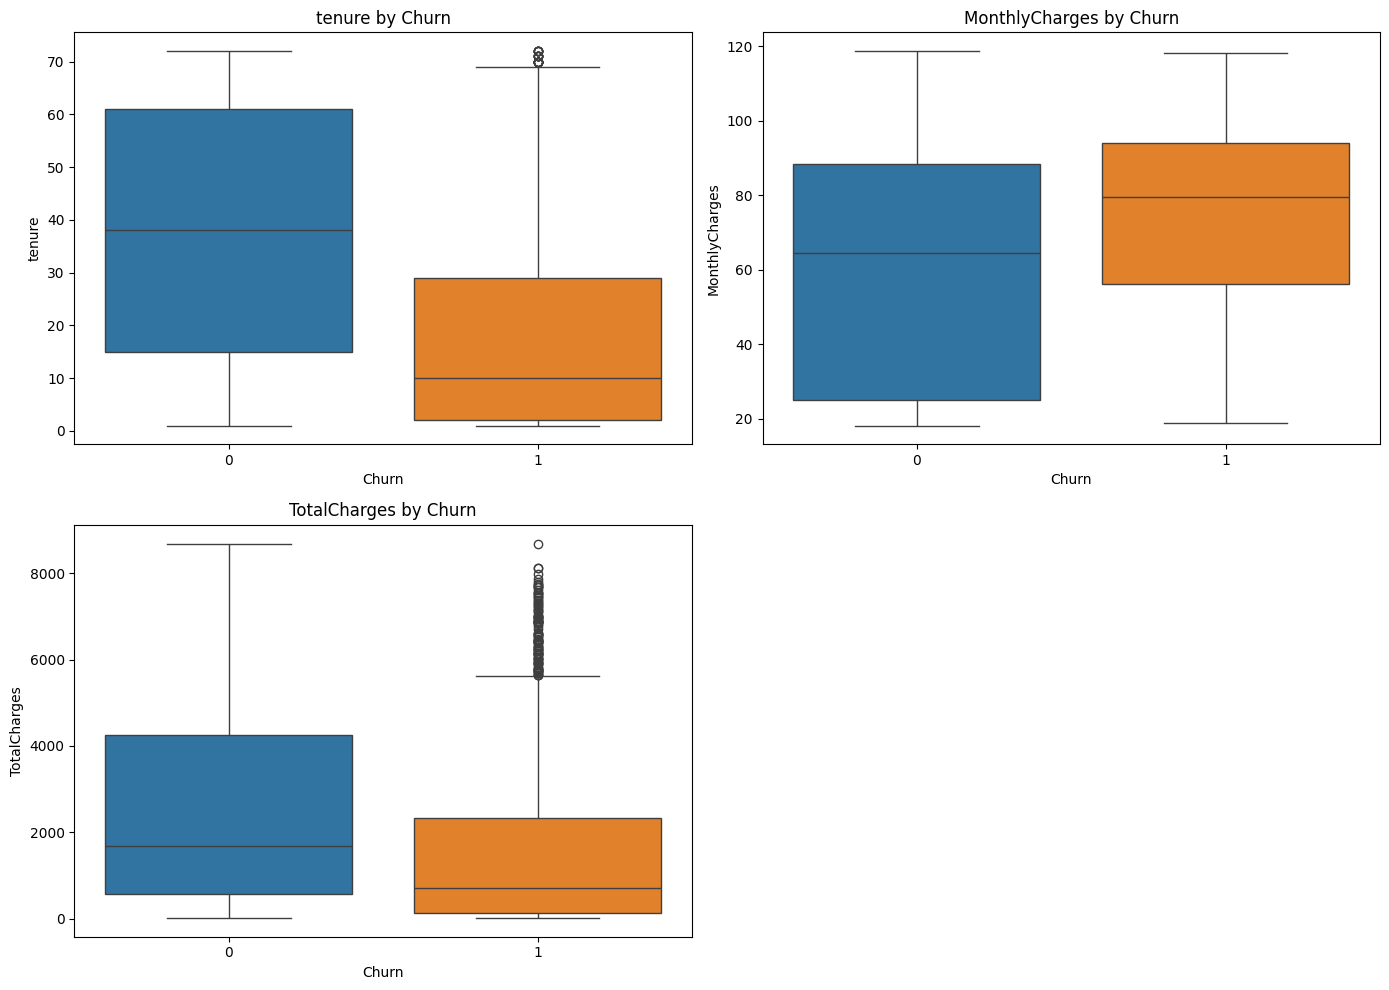

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Define your target variable
target = 'Churn'  # Replace with your actual target name

# Optional: columns to exclude
cols_to_remove = ['Churn', 'SeniorCitizen']  # Customize this list

# Select numeric features (and remove excluded ones)
num_cols = df.select_dtypes(include='number').columns.tolist()
filtered_cols = [col for col in num_cols if col not in cols_to_remove]

# Subplot layout
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5))
axes = axes.flatten()

# Plot each numeric feature as a boxplot
for i, col in enumerate(filtered_cols):
    sns.boxplot(data=df, x=target, y=col, ax=axes[i], hue=target, legend=False)
    axes[i].set_title(f'{col} by {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel(col)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

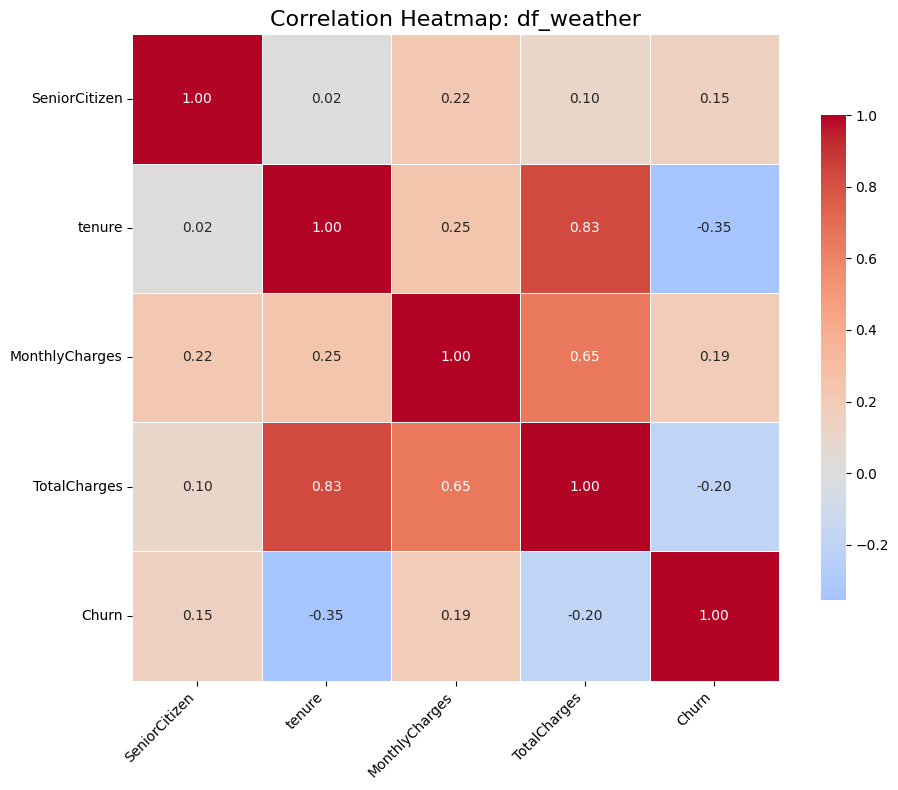

In [ ]:
# correlation matrix
corr_matrix = df.corr(numeric_only=True)  # Use numeric_only=True for pandas >=1.5

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show correlation coefficients
    cmap='coolwarm',  # Color map
    center=0,         # Center the colormap at zero
    fmt=".2f",        # Format the numbers to 2 decimal places
    square=True,      # Make cells square
    linewidths=0.5,   # Cell border lines
    cbar_kws={"shrink": 0.75}  # Shrink color bar
)
plt.title("Correlation Heatmap: df_weather", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Overview

Categorical (2 levels):
* gender
* Partner
* Dependents
* PhoneService
* PaperlessBilling

Categorical (>2 levels):
* MultipleLines
* InternetService
* OnlineSecurity
* OnlineBackup
* DeviceProtection
* TechSupport
* StreamingTV
* StreamingMovies
* Contract
* PaymentMethod

Numeric:
* SeniorCitizen
* tenure
* MonthlyCharges
* TotalCharges

Target
* Churn (Categorical - 2 levels)





---

# Data Preparation

In [ ]:
df['PaymentMethod_ElectCheck'] = df['PaymentMethod'].map(lambda x: 1 if x =='Electronic check' else 0)

# df['Contract'] = df['Contract'].map({'Month-to-month': 1, 'One year': 2, 'Two year': 3})
# df['InternetService'] = df['InternetService'].map({'No': 1, 'DSL': 2, 'Fiber optic': 3})
# df['OnlineSecurity'] = df['OnlineSecurity'].map({'No internet service': 1, 'Yes': 2, 'No': 3})
# df['OnlineBackup'] = df['OnlineBackup'].map({'No internet service': 1, 'Yes': 2, 'No': 3})
# df['DeviceProtection'] = df['DeviceProtection'].map({'No internet service': 1, 'Yes': 2, 'No': 3})
# df['TechSupport'] = df['TechSupport'].map({'No internet service': 1, 'Yes': 2, 'No': 3})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customerID                7032 non-null   object 
 1   gender                    7032 non-null   object 
 2   SeniorCitizen             7032 non-null   int64  
 3   Partner                   7032 non-null   object 
 4   Dependents                7032 non-null   object 
 5   tenure                    7032 non-null   int64  
 6   PhoneService              7032 non-null   object 
 7   MultipleLines             7032 non-null   object 
 8   InternetService           7032 non-null   object 
 9   OnlineSecurity            7032 non-null   object 
 10  OnlineBackup              7032 non-null   object 
 11  DeviceProtection          7032 non-null   object 
 12  TechSupport               7032 non-null   object 
 13  StreamingTV               7032 non-null   object 
 14  Streamin

# Data Preprocessing

In [ ]:
target = 'Churn'
cols_to_drop = [
                'customerID', 'PaymentMethod', 'SeniorCitizen', 'TotalCharges',
                'gender', 'Partner', 'Dependents','PhoneService','PaperlessBilling',
                'MultipleLines', 'StreamingTV','StreamingMovies', 'Churn'
                  ]

binary_int_cols = ['PaymentMethod_ElectCheck']

ordinal_int_cols = [
'Contract',
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection',
'TechSupport',
]

numeric_cols = [
'tenure',
'MonthlyCharges',
# 'TotalCharges',
]

# binary_categorical_cols = [
# 'gender',
# 'Partner',
# 'Dependents',
# 'PhoneService',
# 'PaperlessBilling'
# ]

# categorical_cols = [
# # 'MultipleLines',
# 'InternetService',
# 'OnlineSecurity',
# 'OnlineBackup',
# 'DeviceProtection',
# 'TechSupport',
# # 'StreamingTV',
# # 'StreamingMovies',
# # 'PaymentMethod',
# ]

In [ ]:
# --- 1. Split features and target ---
X = df.drop(columns=cols_to_drop)
y = df[target]

In [ ]:
print(X.shape)
print(y.shape)

(7032, 9)
(7032,)


In [ ]:
# --- 2. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5625, 9)
(1407, 9)
(5625,)
(1407,)


# Feature-Engine Pipeline

In [ ]:
# feature-engine pipeline
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

churn_pipeline = Pipeline([
        ('categorical_encoder', OrdinalEncoder(encoding_method='ordered',
                       variables=ordinal_int_cols)),
        # ('numeric_scaler', SklearnTransformerWrapper(
        #     transformer=StandardScaler(), variables=numeric_cols)
        # )
])

# ordinal_enc = OrdinalEncoder(
#     # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
#     encoding_method="ordered",
#     variables= ordinal_int_cols,
# )

# numeric_scaler = SklearnTransformerWrapper(
#     transformer=StandardScaler(), variables=numeric_cols
# )

In [ ]:
churn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('categorical_encoder',
                 OrdinalEncoder(variables=['Contract', 'InternetService',
                                           'OnlineSecurity', 'OnlineBackup',
                                           'DeviceProtection',
                                           'TechSupport']))])

In [ ]:
encoder = churn_pipeline.named_steps['categorical_encoder']
encoder.encoder_dict_

{'Contract': {'Two year': 0, 'One year': 1, 'Month-to-month': 2},
 'InternetService': {'No': 0, 'DSL': 1, 'Fiber optic': 2},
 'OnlineSecurity': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'OnlineBackup': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'DeviceProtection': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'TechSupport': {'No internet service': 0, 'Yes': 1, 'No': 2}}

In [ ]:
encoder.variables_

['Contract',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport']

In [ ]:
X_train = churn_pipeline.transform(X_train)
X_test = churn_pipeline.transform(X_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5625, 9)
(1407, 9)


In [ ]:
X_train.head()

,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,MonthlyCharges,PaymentMethod_ElectCheck
1408,65,2,1,1,1,1,0,94.55,0
6992,26,1,2,2,1,1,2,35.75,1
3349,68,2,2,1,1,1,0,90.20,0
4486,3,2,2,1,2,2,2,84.30,1
3535,49,1,1,2,2,2,2,40.65,0


# Scikit-learn Pipeline

In [ ]:
# # --- 4. Column transformer for preprocessing ---
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_cols),
#         # ('bin_cat', categorical_transformer, binary_categorical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ],
#     remainder='passthrough'  # Let binary_int_cols and ordinary_int_cols through as-is
# )

In [ ]:
# # --- 5. Fit preprocessing pipeline only ---
# preprocessor.fit(X_train)

In [ ]:
# print(preprocessor.n_features_in_)
# print(preprocessor.feature_names_in_)

In [ ]:
# preprocessor.get_feature_names_out()

In [ ]:
# preprocessor.get_params()

In [ ]:
# # --- 6. Transform train and test data ---
# X_train_preprocessed = preprocessor.transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

# Current DMatrix (Data Matrix)

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:

print(dtrain.feature_types)
print(dtrain.feature_names)

['int', 'int', 'int', 'int', 'int', 'int', 'int', 'float', 'int']
['tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'MonthlyCharges', 'PaymentMethod_ElectCheck']


In [ ]:
dtrain.get_label()

array([0., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [ ]:
print(dtrain.get_data().toarray())
print('#' * 100)
dtrain.get_data()

[[65.    2.    1.   ...  0.   94.55  0.  ]
 [26.    1.    2.   ...  2.   35.75  1.  ]
 [68.    2.    2.   ...  0.   90.2   0.  ]
 ...
 [36.    1.    1.   ...  0.   92.9   0.  ]
 [10.    1.    2.   ...  1.   65.9   0.  ]
 [ 1.    2.    2.   ...  2.   74.7   1.  ]]
####################################################################################################


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 50625 stored elements and shape (5625, 9)>

# Define Model Hyperparameters

| Parameter                   | Description                                                 | Default         | Options / Notes                                                                                                    |
| --------------------------- | ----------------------------------------------------------- | --------------- | ------------------------------------------------------------------------------------------------------------------ |
| **`booster`**               | Type of booster to use                                      | `"gbtree"`      | `"gbtree"` (tree-based, most common), `"gblinear"` (linear model), `"dart"` (dropout boosting, like dropout in NN) |
| **`n_estimators`**          | Number of boosting rounds (trees)                           | `100`           | Any positive integer; often tuned with `early_stopping_rounds`                                                     |
| **`learning_rate` / `eta`** | Step size shrinkage to prevent overfitting                  | `0.3`           | Typical: `0.01–0.3`. Lower → slower learning but more stable                                                       |
| **`max_depth`**             | Maximum depth of trees                                      | `6`             | Small values (`3–6`) work well for most cases; higher → more complex model                                         |
| **`min_child_weight`**      | Minimum sum of instance weights (hessian) needed in a child | `1`             | Higher → more conservative trees, prevents overfitting                                                             |
| **`gamma`**                 | Minimum loss reduction required to split a node             | `0`             | Larger values → more conservative (prunes splits)                                                                  |
| **`subsample`**             | Fraction of training samples used per tree                  | `1.0`           | Typical: `0.5–0.9`. Helps prevent overfitting                                                                      |
| **`colsample_bytree`**      | Fraction of features used per tree                          | `1.0`           | Typical: `0.5–0.9`. Feature-level regularization                                                                   |
| **`colsample_bylevel`**     | Fraction of features per tree level                         | `1.0`           | Useful for very high-dimensional data                                                                              |
| **`colsample_bynode`**      | Fraction of features per tree split                         | `1.0`           | Similar to `max_features` in Random Forests                                                                        |
| **`lambda`**                | L2 regularization term on weights                           | `1`             | Larger → more conservative model                                                                                   |
| **`alpha`**                 | L1 regularization term on weights                           | `0`             | Encourages sparsity in leaf weights                                                                                |
| **`scale_pos_weight`**      | Balances positive/negative weights for imbalanced classes   | `1`             | >1 if positive class is rare; e.g. `sum(neg)/sum(pos)`                                                             |
| **`max_delta_step`**        | Maximum delta step for each leaf weight                     | `0`             | Rarely used; set >0 for highly imbalanced data (e.g. `1–10`)                                                       |
| **`tree_method`**           | Algorithm for constructing trees                            | `"auto"`        | `"auto"`, `"exact"`, `"approx"`, `"hist"`, `"gpu_hist"` (GPU)                                                      |
| **`n_jobs`**                | Number of parallel threads                                  | `max available` | Set for CPU parallelism                                                                                            |

---

# XGBoost Objectives and Evaluation Metrics

| Type            | Objective Type | Name               | Description / Definition                                                                                           |
| --------------- | -------------- | ------------------ | ------------------------------------------------------------------------------------------------------------------ |
| **Objective**   | `binary`       | `binary:logistic`  | Binary classification using logistic regression. Outputs probabilities with sigmoid. Most common for binary tasks. |
| **Objective**   | `binary`       | `binary:hinge`     | Binary classification using hinge loss (like SVM). Outputs hard class labels (0 or 1).                             |
| **Objective**   | `binary`       | `binary:logitraw`  | Outputs raw margin (pre-sigmoid). Useful for custom loss or post-processing.                                       |
| **Objective**   | `regression`   | `reg:squarederror` | Regression with squared error (L2 loss). Predicts continuous value. Default for regression tasks.                  |
| **Objective**   | `regression`   | `reg:logistic`     | Regression using logistic function. Outputs values in (0, 1).                                                      |
| **Objective**   | `multiclass`   | `multi:softmax`    | Multiclass classification. Outputs hard class labels. Requires `num_class`.                                        |
| **Objective**   | `multiclass`   | `multi:softprob`   | Multiclass classification. Outputs class probabilities. Requires `num_class`.                                      |
| **Objective**   | `ranking`      | `rank:pairwise`    | Ranking objective using LambdaRank loss. Optimizes item pairs.                                                     |
| **Objective**   | `ranking`      | `rank:ndcg`        | Ranking objective optimizing Normalized Discounted Cumulative Gain.                                                |
| **Objective**   | `ranking`      | `rank:map`         | Ranking objective optimizing Mean Average Precision (MAP).                                                         |
| **Eval Metric** | `binary`       | `logloss`          | Binary cross-entropy loss. Lower is better.                                                                        |
| **Eval Metric** | `binary`       | `error`            | Binary classification error rate (0–1).                                                                            |
| **Eval Metric** | `binary`       | `auc`              | Area Under ROC Curve — good for balanced and unbalanced data.                                                      |
| **Eval Metric** | `binary`       | `aucpr`            | Area Under Precision-Recall Curve — better for imbalanced classes.                                                 |
| **Eval Metric** | `regression`   | `rmse`             | Root Mean Squared Error — sensitive to large errors.                                                               |
| **Eval Metric** | `regression`   | `mae`              | Mean Absolute Error — more robust to outliers than RMSE.                                                           |
| **Eval Metric** | `regression`   | `rmsle`            | Root Mean Squared Log Error — good for skewed targets.                                                             |
| **Eval Metric** | `regression`   | `mape`             | Mean Absolute Percentage Error — evaluates error as percentage.                                                    |
| **Eval Metric** | `multiclass`   | `mlogloss`         | Multiclass log loss (cross-entropy). Lower is better.                                                              |
| **Eval Metric** | `multiclass`   | `merror`           | Multiclass classification error rate.                                                                              |
| **Eval Metric** | `ranking`      | `map`              | Mean Average Precision — used in ranking.                                                                          |
| **Eval Metric** | `ranking`      | `ndcg`             | Normalized Discounted Cumulative Gain — ranking metric.                                                            |

In [ ]:
# Define hyperparameters

params = {
    "objective": "binary:logistic", # Specify the learning task and the corresponding learning objective Outputs probability (via logistic sigmoid)
    "booster": "gbtree", # Specify which booster to use (default)
    "eval_metric": ["logloss", "auc"], # Specify the evaluation metric "auc"
    "learning_rate": 0.1, # step size shrinkage to prevent overfitting
    "max_depth": 4,
    "lambda": 1, # L2 regularization term on weights (default: 1)
    "random_state": 42,
    }

evals = [(dtest, "validation"), (dtrain, "train")]

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n, # number of boosting iterations (default: 10)
   evals=evals,
   verbose_eval=10, # Every 10 rounds
   early_stopping_rounds=10 # If validation loss stops improving for a specified number of rounds, it automatically stops training.
)

[0]	validation-logloss:0.55247	validation-auc:0.82279	train-logloss:0.55090	train-auc:0.84102
[10]	validation-logloss:0.45203	validation-auc:0.83309	train-logloss:0.43586	train-auc:0.85798
[20]	validation-logloss:0.43172	validation-auc:0.83525	train-logloss:0.40620	train-auc:0.86297
[30]	validation-logloss:0.42621	validation-auc:0.83644	train-logloss:0.39487	train-auc:0.86704
[40]	validation-logloss:0.42518	validation-auc:0.83670	train-logloss:0.38799	train-auc:0.87099
[50]	validation-logloss:0.42639	validation-auc:0.83561	train-logloss:0.38432	train-auc:0.87314
[60]	validation-logloss:0.42734	validation-auc:0.83488	train-logloss:0.38105	train-auc:0.87541
[70]	validation-logloss:0.42764	validation-auc:0.83455	train-logloss:0.37831	train-auc:0.87749
[80]	validation-logloss:0.42929	validation-auc:0.83309	train-logloss:0.37544	train-auc:0.87971
[90]	validation-logloss:0.42990	validation-auc:0.83251	train-logloss:0.37325	train-auc:0.88130
[99]	validation-logloss:0.43029	validation-auc:0.83

In [ ]:
# Inspecting XGBoost Booster object (from xgb.train)

# --- Best iteration info (after early stopping) ---
print("\n=== Best Iteration Info ===")
print(f"Best iteration       : {model.best_iteration}")
print(f"Best score achieved  : {model.best_score}")

# --- Booster attributes dictionary ---
print("\n=== Booster Attributes ===")
attrs = model.attributes()
if attrs:
    for k, v in attrs.items():
        print(f"  {k}: {v}")
else:
    print("  (No custom attributes found)")

# --- Feature importance ---
print("\n=== Feature Importance ===")
importance = model.get_score(importance_type="weight") #default: counts number of times feature used across all split
if importance:
    for feat, score in sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {feat}: {score:.4f}")
else:
    print("  (No features found — was the model trained on empty data?)")


=== Best Iteration Info ===
Best iteration       : 99
Best score achieved  : 0.8826981787556585

=== Booster Attributes ===
  best_iteration: 99
  best_score: 0.8826981787556585

=== Feature Importance ===
  MonthlyCharges: 582.0000
  tenure: 374.0000
  Contract: 84.0000
  PaymentMethod_ElectCheck: 72.0000
  OnlineSecurity: 53.0000
  TechSupport: 41.0000
  OnlineBackup: 37.0000
  InternetService: 21.0000
  DeviceProtection: 19.0000


In [ ]:
model.get_score(importance_type="gain")

{'tenure': 5.486041069030762,
 'InternetService': 35.35755157470703,
 'OnlineSecurity': 13.556635856628418,
 'OnlineBackup': 3.9970827102661133,
 'DeviceProtection': 1.4125398397445679,
 'TechSupport': 11.155735969543457,
 'Contract': 70.2041244506836,
 'MonthlyCharges': 3.2820425033569336,
 'PaymentMethod_ElectCheck': 4.393462181091309}

In [ ]:
model.eval(dtest, 'dtest')

'[0]\tdtest-logloss:0.43029457908031060\tdtest-auc:0.83233766973303447'

# Model Predictions

In [ ]:
# predicted probabilities
y_pred_prob = model.predict(dtest)
y_pred_prob

array([0.02114053, 0.6719395 , 0.01717857, ..., 0.04813221, 0.01543205,
       0.01138532], dtype=float32)

In [ ]:
# convert to predictions
def predict(prob, threshold):
    return np.where(prob>threshold, 1, 0)

y_pred = predict(y_pred_prob, 0.5)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

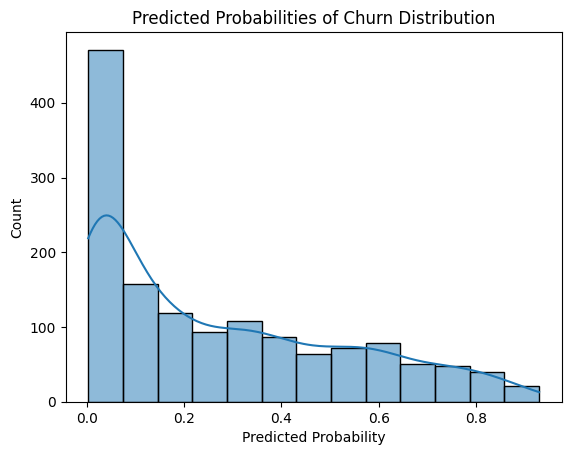

In [ ]:
# check distribution of predicted probabilities
sns.histplot(y_pred_prob, kde=True)
plt.title('Predicted Probabilities of Churn Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show();

# Evaluation Metrics

=== Metric Scores ===
Accuracy:  0.788
Balanced Accuracy:  0.702
Precision: 0.622
Recall:    0.519
F1 Score:  0.566
ROC AUC:   0.832
PR AUC:    0.638


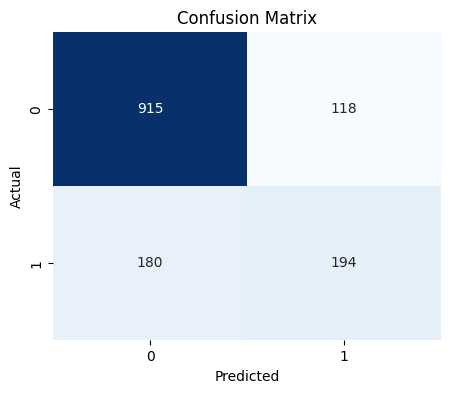


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.836     0.886     0.860      1033
           1      0.622     0.519     0.566       374

    accuracy                          0.788      1407
   macro avg      0.729     0.702     0.713      1407
weighted avg      0.779     0.788     0.782      1407


=== Classification Rates ===
True Positive Rate - Recall(1) (% of actual positives correctly predicted)): 0.5187
True Negative Rate - Recall(0) (% of actual negatives correctly predicted): 0.8858
Positive Prediction Rate - Precision(1) (% of predicted positives correctly predicted): 0.6218
Negative Prediction Rate - Precision(0) (% of predicted negatives correctly predicted): 0.8356
False Negative Rate (% of actual positives that were incorrectly predicted): 0.4813
False Positive Rate (% of actual negatives that were incorrectly predicted): 0.1142
Balanced Accuracy - Avg. Recall for each class = (Recall(0) + Recall(1)) / 2 (macro avg

In [ ]:
# Binary Classification Metrics Visualization Script
# --------------------------------------------------
# Assumes:
# - `y_test`: true labels (0 or 1)
# - `y_pred`: predicted class labels from model
# - `y_pred_prob`: predicted probabilities from model.predict_proba(X_test)[:, 1]

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example placeholders (replace these with your real values)
# y_test = ...
# y_pred = ...

# y_pred_prob = model.predict_proba(X_test)[:, 1]

# 1. Basic metric scores
accuracy  = accuracy_score(y_test, y_pred)
balanced_accuracy  = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_pred_prob)
avg_prec  = average_precision_score(y_test, y_pred_prob)

print("=== Metric Scores ===")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Balanced Accuracy:  {balanced_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")
print(f"PR AUC:    {avg_prec:.3f}")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Classification Report: Precision, Recall, F1, Accuray
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

# 6. Classification Rates
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)  # True Positive Rate (Recall or Sensitivity)
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (tp + fn)  # False Negative Rate
ppr = tp / (tp + fp)  # Positive Prediction Rate (Precision)
npr = tn / (tn + fn)  # Negative Prediction Rate
fpr = fp / (tn + fp)  # False Positive Rate

print("\n=== Classification Rates ===")
print(f"True Positive Rate - Recall(1) (% of actual positives correctly predicted)): {tpr:.4f}")
print(f"True Negative Rate - Recall(0) (% of actual negatives correctly predicted): {tnr:.4f}")
print(f"Positive Prediction Rate - Precision(1) (% of predicted positives correctly predicted): {ppr:.4f}")
print(f"Negative Prediction Rate - Precision(0) (% of predicted negatives correctly predicted): {npr:.4f}")
print(f"False Negative Rate (% of actual positives that were incorrectly predicted): {fnr:.4f}")
print(f"False Positive Rate (% of actual negatives that were incorrectly predicted): {fpr:.4f}")
print(f"Balanced Accuracy - Avg. Recall for each class = (Recall(0) + Recall(1)) / 2 (macro avg): {balanced_accuracy:.4f}")

---

# Precision, Recall, F1 for Different Probability Thresholds

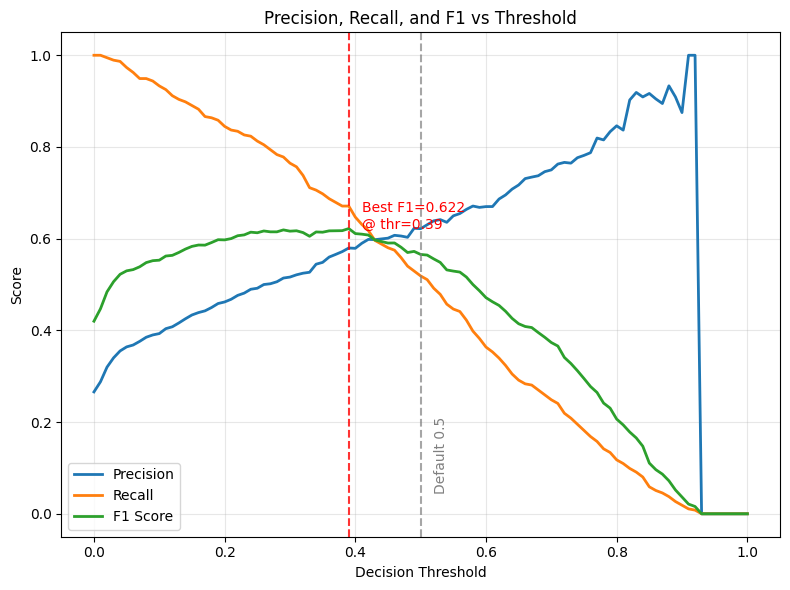

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Define thresholds
thresholds = np.linspace(0, 1, 101)

# Containers
precision, recall, f1 = [], [], []

# Compute metrics at each threshold
for t in thresholds:
    y_pred_thresh = (y_pred_prob >= t).astype(int)
    precision.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recall.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1.append(f1_score(y_test, y_pred_thresh, zero_division=0))

# Find threshold with max F1
best_idx = np.argmax(f1)
best_thresh = thresholds[best_idx]
best_f1 = f1[best_idx]

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision, label="Precision", linewidth=2)
plt.plot(thresholds, recall, label="Recall", linewidth=2)
plt.plot(thresholds, f1, label="F1 Score", linewidth=2)

# Add default threshold marker (0.5)
plt.axvline(x=0.5, color="gray", linestyle="--", alpha=0.7)
plt.text(0.52, 0.05, "Default 0.5", rotation=90, color="gray")

# Add best F1 marker
plt.axvline(x=best_thresh, color="red", linestyle="--", alpha=0.8)
plt.text(best_thresh+0.02, best_f1,
         f"Best F1={best_f1:.3f}\n@ thr={best_thresh:.2f}",
         color="red")

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

# ROC Curve - AUC

TPR array shape: (509,)
FPR array shape: (509,)
Thresholds array shape: (509,)
True Positive Rate - Recall(1): % of actual positives correctly predicted
False Positive Rate: % of actual negatives that were incorrectly predicted


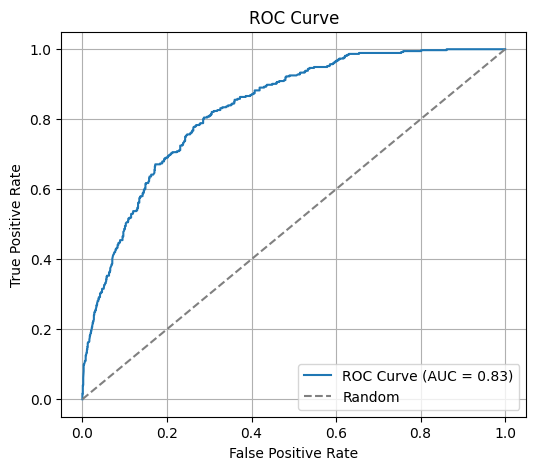

In [ ]:
# from yellowbrick.classifier import ROCAUC

# visualizer = ROCAUC(model, classes=["not_churn", "is_churn"])
# visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)        # Evaluate the model on the test data
# visualizer.show();                       # Finalize and show the figure

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
print(f"TPR array shape: {tpr.shape}")
print(f"FPR array shape: {fpr.shape}")
print(f"Thresholds array shape: {roc_thresholds.shape}")
print("True Positive Rate - Recall(1): % of actual positives correctly predicted")
print("False Positive Rate: % of actual negatives that were incorrectly predicted")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show();

In [ ]:
# Optimizing Threshold based on TPR and FPR
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]
roc_auc_optimal = roc_auc_score(y_test, y_pred_prob, max_fpr=optimal_fpr)

print(f"Optimal Index: {optimal_idx}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Optimal TPR: {optimal_tpr:.3f}")
print(f"Optimal FPR: {optimal_fpr:.3f}")
print(f"ROC AUC # Optimal: {roc_auc_optimal:.3f}")

Optimal Index: 289
Optimal Threshold: 0.266
Optimal TPR: 0.805
Optimal FPR: 0.288
ROC AUC # Optimal: 0.733


---

# Probability Threshold Tuning

## Recalculating Predictions & Metrics Based on Manual Probability

In [ ]:
# set up a function to define a class based
# on a threshold

def predict(prob, threshold):
    return np.where(prob>threshold, 1, 0)

def classification_metric_threshold(model, y_test, y_pred_prob, threshold):

    # Binary Classification Metrics Visualization Script
    # --------------------------------------------------
    # Assumes:
    # - `y_test`: true labels (0 or 1)
    # - `y_pred`: predicted class labels from model
    # - `y_pred_prob`: predicted probabilities from model.predict_proba(X_test)[:, 1]

    from sklearn.metrics import (
        accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report,
        roc_auc_score, average_precision_score,
        roc_curve, precision_recall_curve
    )
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    y_pred = predict(y_pred_prob, threshold)

    # Basic metric scores
    accuracy  = accuracy_score(y_test, y_pred)
    balanced_accuracy  = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    roc_auc   = roc_auc_score(y_test, y_pred_prob)
    avg_prec  = average_precision_score(y_test, y_pred_prob)

    print("=== Metric Scores ===")
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Balanced Accuracy:  {balanced_accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"ROC AUC:   {roc_auc:.3f}")
    print(f"PR AUC:    {avg_prec:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


    # Classification Report: Precision, Recall, F1, Accuray
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, digits=3))

    # Classification Rates
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn)  # True Positive Rate (Recall or Sensitivity)
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (tp + fn)  # False Negative Rate
    ppr = tp / (tp + fp)  # Positive Prediction Rate (Precision)
    npr = tn / (tn + fn)  # Negative Prediction Rate
    fpr = fp / (tn + fp)  # False Positive Rate

    print("\n=== Classification Rates ===")
    print(f"True Positive Rate - Recall(1) (% of actual positives correctly predicted)): {tpr:.4f}")
    print(f"True Negative Rate - Recall(0) (% of actual negatives correctly predicted): {tnr:.4f}")
    print(f"Positive Prediction Rate - Precision(1) (% of predicted positives correctly predicted): {ppr:.4f}")
    print(f"Negative Prediction Rate - Precision(0) (% of predicted negatives correctly predicted): {npr:.4f}")
    print(f"False Negative Rate (% of actual positives that were incorrectly predicted): {fnr:.4f}")
    print(f"False Positive Rate (% of actual negatives that were incorrectly predicted): {fpr:.4f}")
    print(f"Balanced Accuracy - Avg. Recall for each class = (Recall(0) + Recall(1)) / 2 (macro avg): {balanced_accuracy:.4f}")

=== Metric Scores ===
Accuracy:  0.727
Balanced Accuracy:  0.754
Precision: 0.492
Recall:    0.813
F1 Score:  0.613
ROC AUC:   0.832
PR AUC:    0.638


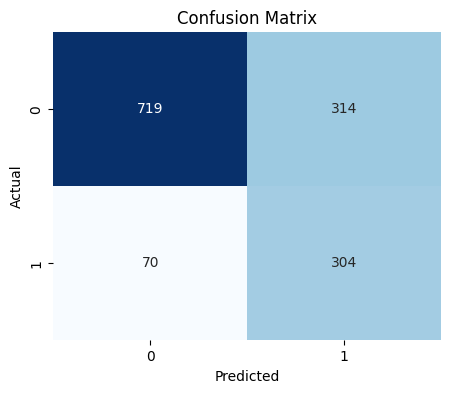


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.911     0.696     0.789      1033
           1      0.492     0.813     0.613       374

    accuracy                          0.727      1407
   macro avg      0.702     0.754     0.701      1407
weighted avg      0.800     0.727     0.742      1407


=== Classification Rates ===
True Positive Rate - Recall(1) (% of actual positives correctly predicted)): 0.8128
True Negative Rate - Recall(0) (% of actual negatives correctly predicted): 0.6960
Positive Prediction Rate - Precision(1) (% of predicted positives correctly predicted): 0.4919
Negative Prediction Rate - Precision(0) (% of predicted negatives correctly predicted): 0.9113
False Negative Rate (% of actual positives that were incorrectly predicted): 0.1872
False Positive Rate (% of actual negatives that were incorrectly predicted): 0.3040
Balanced Accuracy - Avg. Recall for each class = (Recall(0) + Recall(1)) / 2 (macro avg

In [ ]:
classification_metric_threshold(model, y_test, y_pred_prob, threshold=0.25)

---

# Feature Importance

* XGBoost importance_type="`weight`"
  * → Counts the number of times a feature is used to split across all trees.
  * → This is the default importance type when you call XGBClassifier.

* `gain`: Average gain (loss reduction) when a feature is used.
* `cover`: Average coverage (# of samples affected) when a feature is used.
* `total_gain`: Total gain over all splits for a feature.
* `total_cover`: Total coverage over all splits for a feature.

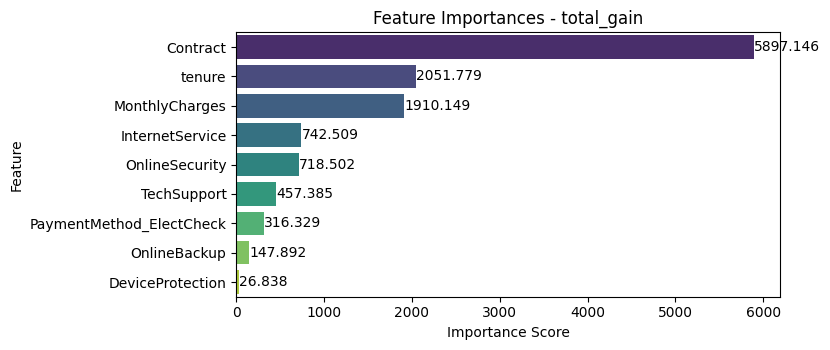

In [ ]:
# get feature importances
index = 3
importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

importances = list(model.get_score(importance_type=importance_type[index]).values())
feature_names = list(model.get_score(importance_type=importance_type[index]).keys())

# Create a pandas Series for easy plotting
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, len(feature_names) * 0.4))
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
ax = sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')

plt.title(f"Feature Importances - {importance_type[index]}")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
# Add labels to the bars
for i, v in enumerate(feat_imp):
    ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center')

plt.show()

---

# XGBoost Cross Validation

In [ ]:
n = 100

results = xgb.cv(
   params, dtrain,
   num_boost_round=n,
   nfold=5,
   metrics=["logloss", "auc", "error"],
)

In [ ]:
results.head()

,train-logloss-mean,train-logloss-std,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-logloss-mean,test-logloss-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.550760,0.002419,0.841881,0.004464,0.265778,0.002463,0.552464,0.009343,0.827226,0.011732,0.265778,0.009850
1,0.528303,0.002338,0.846877,0.005103,0.265778,0.002463,0.531096,0.009225,0.833106,0.012360,0.265778,0.009850
2,0.510069,0.002506,0.850025,0.005832,0.265778,0.002463,0.514465,0.009030,0.835112,0.013436,0.265778,0.009850
3,0.494760,0.002546,0.852285,0.004643,0.265778,0.002463,0.499782,0.008610,0.837357,0.012641,0.265778,0.009850
4,0.481903,0.002436,0.853394,0.004040,0.261022,0.005880,0.488062,0.009220,0.839337,0.014406,0.263467,0.010481


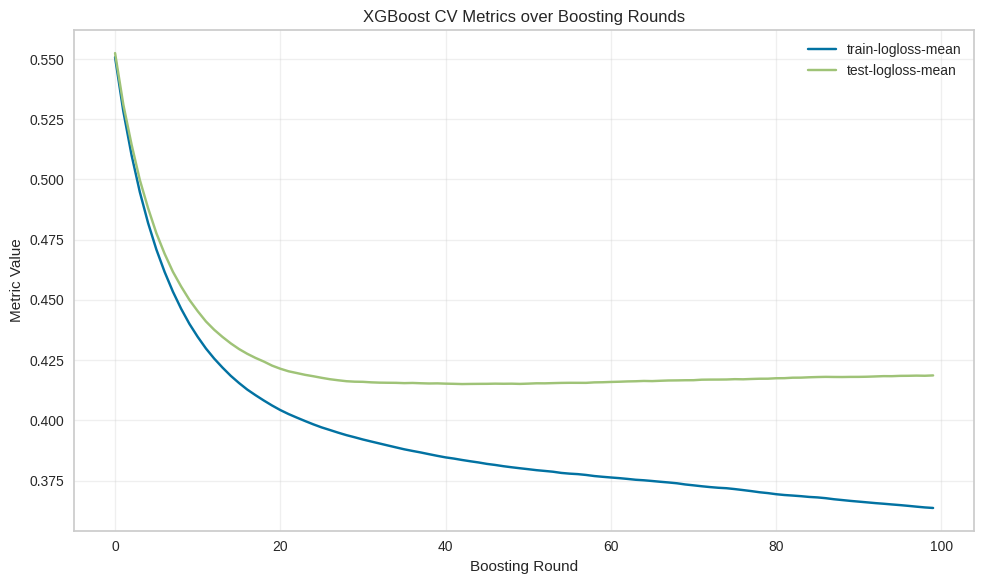

In [ ]:
import matplotlib.pyplot as plt

# Run cross-validation (already done in your case)
# results = xgb.cv(...)

# Plot setup
plt.figure(figsize=(10, 6))

metric_name = "logloss" # ["logloss", "auc", "error"]

# Plot all metrics included in cv
for metric in results.columns:
    if "mean" in metric and metric_name in metric and "std" not in metric:
        plt.plot(results[metric], label=metric)

# Add titles, legend, etc.
plt.title("XGBoost CV Metrics over Boosting Rounds")
plt.xlabel("Boosting Round")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 # Scikit-learn API Wrapper

In [ ]:
params = {
    "objective": "binary:logistic", # Specify the learning task and the corresponding learning objective Outputs probability (via logistic sigmoid)
    "booster": "gbtree", # Specify which booster to use (default)
    "eval_metric": ["logloss", "auc"], # Specify the evaluation metric "auc"
    "learning_rate": 0.1, # step size shrinkage to prevent overfitting
    "max_depth": 4,
    "lambda": 1, # L2 regularization term on weights (default: 1)
    "random_state": 42,
    }

In [ ]:
# Train a model using the scikit-learn API
xgb_classifier = xgb.XGBClassifier(n_estimators=100,
                                   objective='binary:logistic',
                                   eval_metric=['logloss', 'auc'],
                                   tree_method='hist',
                                   max_depth=4,
                                   enable_categorical=True,
                                   learning_rate = 0.1,
                                   early_stopping_rounds=10,
                                   random_state=42,
                                   )

# model fitting, passing eval datasets
xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# # Convert the model to a native API model
# model = xgb_classifier.get_booster()

[0]	validation_0-logloss:0.55247	validation_0-auc:0.82279
[1]	validation_0-logloss:0.53177	validation_0-auc:0.82782
[2]	validation_0-logloss:0.51527	validation_0-auc:0.83016
[3]	validation_0-logloss:0.50150	validation_0-auc:0.83026
[4]	validation_0-logloss:0.49076	validation_0-auc:0.83087
[5]	validation_0-logloss:0.48157	validation_0-auc:0.83110
[6]	validation_0-logloss:0.47386	validation_0-auc:0.83074
[7]	validation_0-logloss:0.46695	validation_0-auc:0.83167
[8]	validation_0-logloss:0.46158	validation_0-auc:0.83084
[9]	validation_0-logloss:0.45668	validation_0-auc:0.83209
[10]	validation_0-logloss:0.45203	validation_0-auc:0.83309
[11]	validation_0-logloss:0.44831	validation_0-auc:0.83371
[12]	validation_0-logloss:0.44576	validation_0-auc:0.83296
[13]	validation_0-logloss:0.44266	validation_0-auc:0.83360
[14]	validation_0-logloss:0.44050	validation_0-auc:0.83360
[15]	validation_0-logloss:0.43865	validation_0-auc:0.83364
[16]	validation_0-logloss:0.43695	validation_0-auc:0.83388
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['logloss', 'auc'],
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
print(xgb_classifier.score(X_train, y_train))
print(xgb_classifier.score(X_test, y_test))

0.8156444444444444
0.7953091684434968


In [ ]:
xgb_classifier.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 10,
 'enable_categorical': True,
 'eval_metric': ['logloss', 'auc'],
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# 📌 1. Best score from early stopping
print(f"Best score           : {xgb_classifier.best_score}")

# 📌 2. Best iteration (tree index with best validation score)
print(f"Best iteration       : {xgb_classifier.best_iteration}")

# ⚙️ 3. Device used (CPU or GPU)
print(f"Device               : {xgb_classifier.device}")

# 📐 4. Number of features model was trained on
print(f"Num input features   : {xgb_classifier.n_features_in_}")

# 📊 5. Eval results over training
print("\n📈 Evaluation Results:")
for dataset, metrics in xgb_classifier.evals_result_.items():
    print(f"  [{dataset}]")
    for metric_name, values in metrics.items():
        print(f"    {metric_name:<15}: Last = {values[-1]:.4f}, Best = {min(values):.4f}")

# 📈 6. Feature importances (default = importance_type='weight')
print("\n🔬 Feature Importances:")
for name, score in zip(xgb_classifier.feature_names_in_, xgb_classifier.feature_importances_):
    print(f"  {name:<20} → {score:.4f}")

Best score           : 0.8370821707192073
Best iteration       : 36
Device               : None
Num input features   : 9

📈 Evaluation Results:
  [validation_0]
    logloss        : Last = 0.4261, Best = 0.4251
    auc            : Last = 0.8358, Best = 0.8228

🔬 Feature Importances:
  tenure               → 0.0502
  InternetService      → 0.2462
  OnlineSecurity       → 0.0862
  OnlineBackup         → 0.0252
  DeviceProtection     → 0.0076
  TechSupport          → 0.0769
  Contract             → 0.4523
  MonthlyCharges       → 0.0272
  PaymentMethod_ElectCheck → 0.0284


# Predictions

In [ ]:
y_pred_api = xgb_classifier.predict(X_test)
y_pred_api

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
y_pred_prob_api = xgb_classifier.predict_proba(X_test)
y_pred_prob_api

array([[0.9722742 , 0.0277258 ],
       [0.34888315, 0.65111685],
       [0.9782625 , 0.02173752],
       ...,
       [0.9519745 , 0.04802549],
       [0.97913355, 0.02086643],
       [0.9795472 , 0.02045282]], dtype=float32)

In [ ]:
pd.DataFrame(y_pred_prob_api).describe()

,0,1
count,1407.000000,1407.000000
mean,0.728219,0.271781
std,0.239689,0.239689
min,0.115001,0.013069
25%,0.543934,0.045145
50%,0.804099,0.195901
75%,0.954855,0.456066
max,0.986931,0.884999


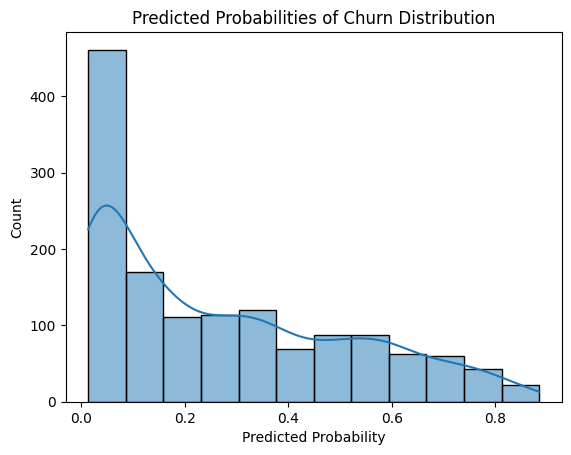

In [ ]:
# check distribution of predicted probabilities for positive class
y_pred_prob_pos = y_pred_prob_api[:, 1]
sns.histplot(y_pred_prob_pos, kde=True)
plt.title('Predicted Probabilities of Churn Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show();

---

# Evaluation Metrics

In [ ]:
y_pred_prob_api

array([[0.9722742 , 0.0277258 ],
       [0.34888315, 0.65111685],
       [0.9782625 , 0.02173752],
       ...,
       [0.9519745 , 0.04802549],
       [0.97913355, 0.02086643],
       [0.9795472 , 0.02045282]], dtype=float32)

=== Metric Scores ===
Accuracy:  0.795
Balanced Accuracy:  0.706
Precision: 0.643
Recall:    0.516
F1 Score:  0.573
ROC AUC:   0.837
PR AUC:    0.645


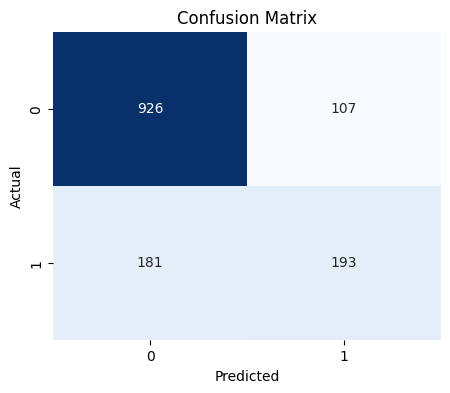


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.836     0.896     0.865      1033
           1      0.643     0.516     0.573       374

    accuracy                          0.795      1407
   macro avg      0.740     0.706     0.719      1407
weighted avg      0.785     0.795     0.788      1407


=== Classification Rates ===
True Positive Rate - Recall(1) (% of actual positives correctly predicted)): 0.5160
True Negative Rate - Recall(0) (% of actual negatives correctly predicted): 0.8964
Positive Prediction Rate - Precision(1) (% of predicted positives correctly predicted): 0.6433
Negative Prediction Rate - Precision(0) (% of predicted negatives correctly predicted): 0.8365
False Negative Rate (% of actual positives that were incorrectly predicted): 0.4840
False Positive Rate (% of actual negatives that were incorrectly predicted): 0.1036
Balanced Accuracy - Avg. Recall for each class = (Recall(0) + Recall(1)) / 2 (macro avg

In [ ]:
# get classification report
classification_metric_threshold(model=xgb_classifier, y_test=y_test, y_pred_prob=y_pred_prob_api[:,1], threshold=0.5)

---

# Precision Recall Curve

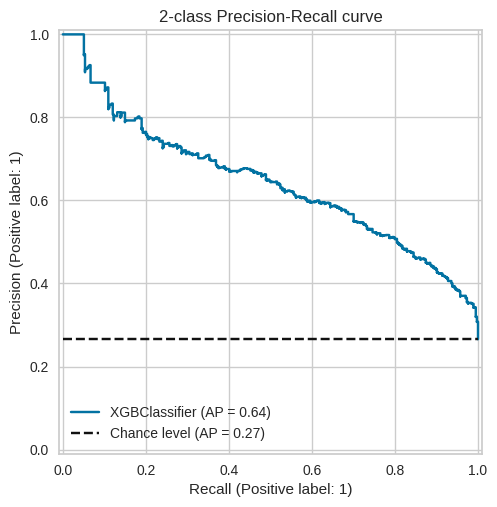

In [ ]:
from sklearn.metrics import (
    precision_recall_curve,
    PrecisionRecallDisplay,
    average_precision_score,
    auc,
)

from yellowbrick.classifier import PrecisionRecallCurve

# plot precision recall curve
model_disp = PrecisionRecallDisplay.from_estimator(xgb_classifier, X_test, y_test, plot_chance_level=True)
_ = model_disp.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
# # first find preciion and recall various at various thresholds
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# # then using these values, determine the area under the curve
# auc_model = auc(recall, precision)
# print('Area under PR Curve: ', auc_model)

# ap_model = average_precision_score(y_test, y_pred_prob)
# print('Average Precision: ', ap_model)

In [ ]:
# print(len(precision))
# print(len(recall))
# print(len(thresholds))

In [ ]:
# f1 = 2 * (precision * recall) / (precision + recall)

# df_pr_curve = pd.DataFrame({
#     'precision': precision[:-1],
#     'recall': recall[:-1],
#     'f1': f1[:-1],
#     'thresholds': thresholds
# })

# df_pr_curve = df_pr_curve[df_pr_curve['recall'] >= 0.7]
# df_pr_curve

---

# Feature Importance - Global

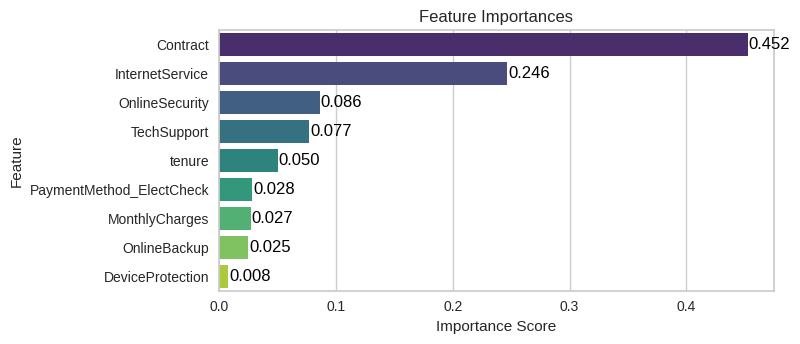

In [ ]:
# get feature importances
importances = xgb_classifier.feature_importances_
feature_names = X_train.columns

# Create a pandas Series for easy plotting
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, len(feature_names) * 0.4))
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
ax = sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')

plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
# Add labels to the bars
for i, v in enumerate(feat_imp):
    ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center')

plt.show()

* Intuition: Features at top of tree, features used to split more often, and features that increase node purity have higher importance
* Feature importance in tree-based models reflects how much a feature contributes to reducing prediction error or impurity (e.g., Gini, MSE) across all trees and splits.

# Partial Dependence Plots - Numeric Feature

In [ ]:
# Let's put the code in a function

def plot_pdp_numeric(model, X, variable, bins=10):

    # to avoid modifying the original dataframe
    X = X.copy()

    # sort variable into bins
    bins = pd.cut(X[variable], bins=bins)

    # determine interval's middle point and n of observations
    pdp = X.groupby(bins, observed=False)[variable].agg(["mean", "count"])

    # calculate partial dependence
    pdp_preds = []
    for value in pdp["mean"]:
        X[variable] = value
        preds = model.predict(X)
        pdp_preds.append(np.mean(preds))
    pdp["pdp_preds"] = pdp_preds

    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pdp_preds"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    ax2.set_ylim(bottom=0)
    plt.show();

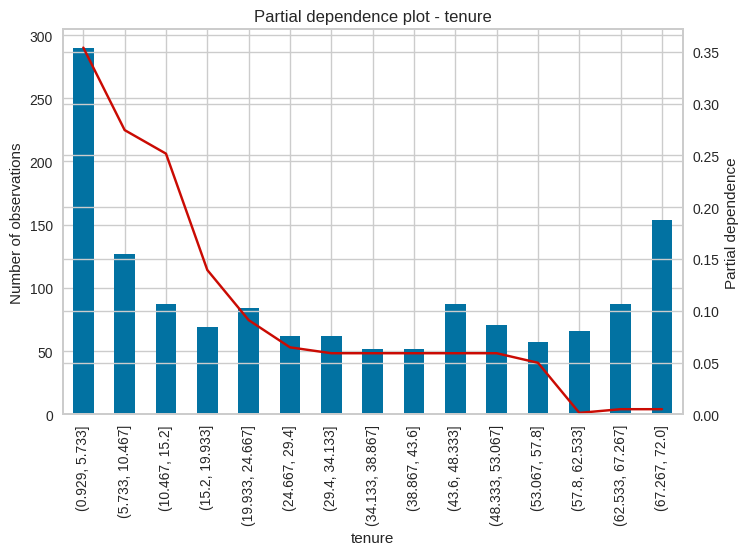

In [ ]:
warnings.filterwarnings("ignore")
plot_pdp_numeric(xgb_classifier, X_test, variable="tenure", bins=15);

* Iteratively set all feature obs to each feature value, make predictions for all obs at each level, holding all other features constant
* y-axis: mean predicted probablity of positive class
* Correlated features can impact results

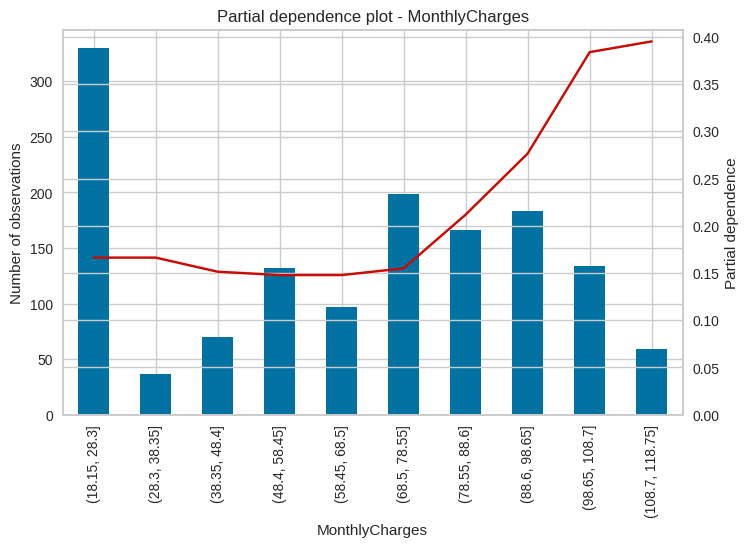

In [ ]:
plot_pdp_numeric(xgb_classifier, X_test, variable="MonthlyCharges", bins=10);

# Partial Dependence Plots - Categorical Feature

In [ ]:
# Let's put the code in a function

def plot_pdp_categorical(model, X, variable):

    # to avoid modifying the original dataframe
    X = X.copy()

    categories = X[variable].unique()
    categories.sort()

    pdp = pd.DataFrame({
    "count": X.groupby([variable])[variable].count(),
    }, index=categories)

    pdp_preds = []

    # calculate partial dependence
    for value in categories:

        # Set the feature to a fixed value
        X[variable] = value

        # Obtain the predictions
        preds = model.predict_proba(X)[:,1]

        # get the prediction average
        pdp_preds.append(np.mean(preds))

    # the predictions average
    pdp["pred"] = pdp_preds

    pdp.reset_index(inplace=True)

    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pred"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    ax2.set_ylim(bottom=0)
    plt.xticks(pdp.index, pdp["index"])
    plt.show();

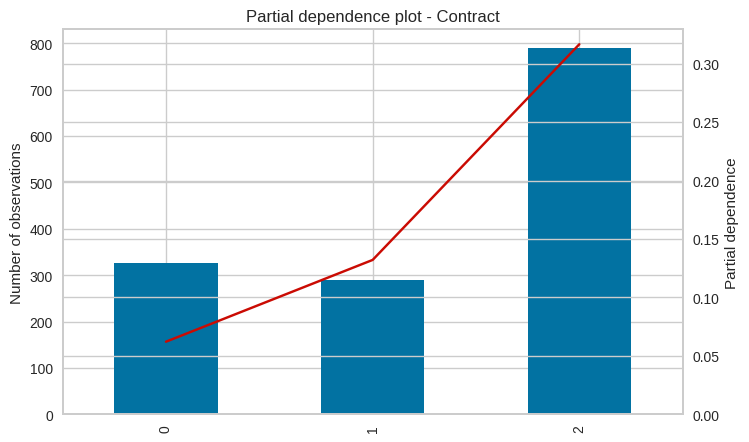

In [ ]:
plot_pdp_categorical(xgb_classifier, X_test, "Contract");

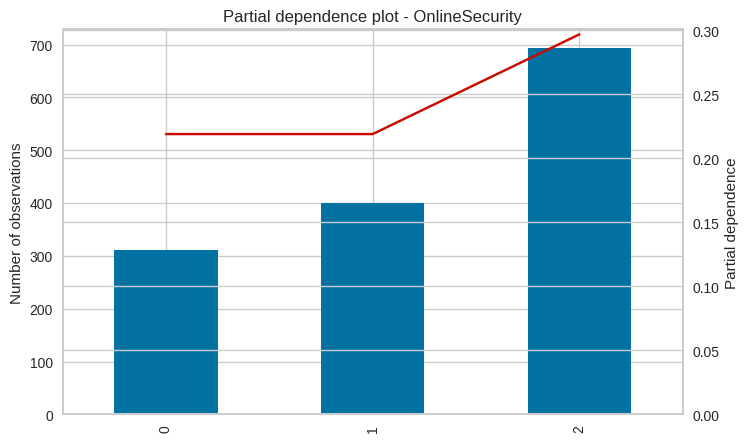

In [ ]:
plot_pdp_categorical(xgb_classifier, X_test, "OnlineSecurity");

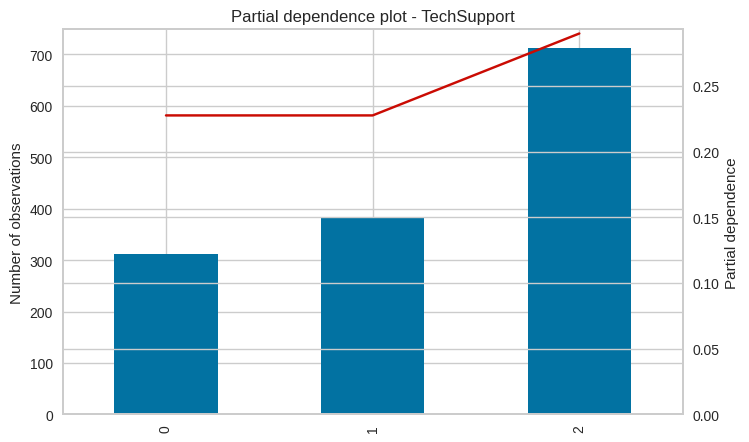

In [ ]:
plot_pdp_categorical(xgb_classifier, X_test, "TechSupport");

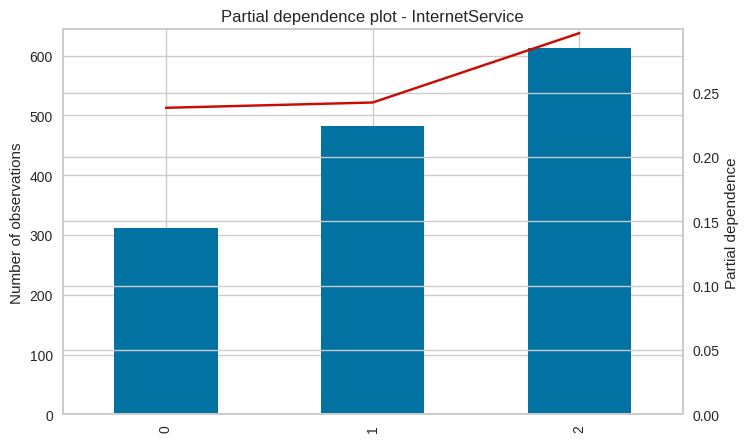

In [ ]:
plot_pdp_categorical(xgb_classifier, X_test, "InternetService");

# Individual Contribution Expectation (ICE)

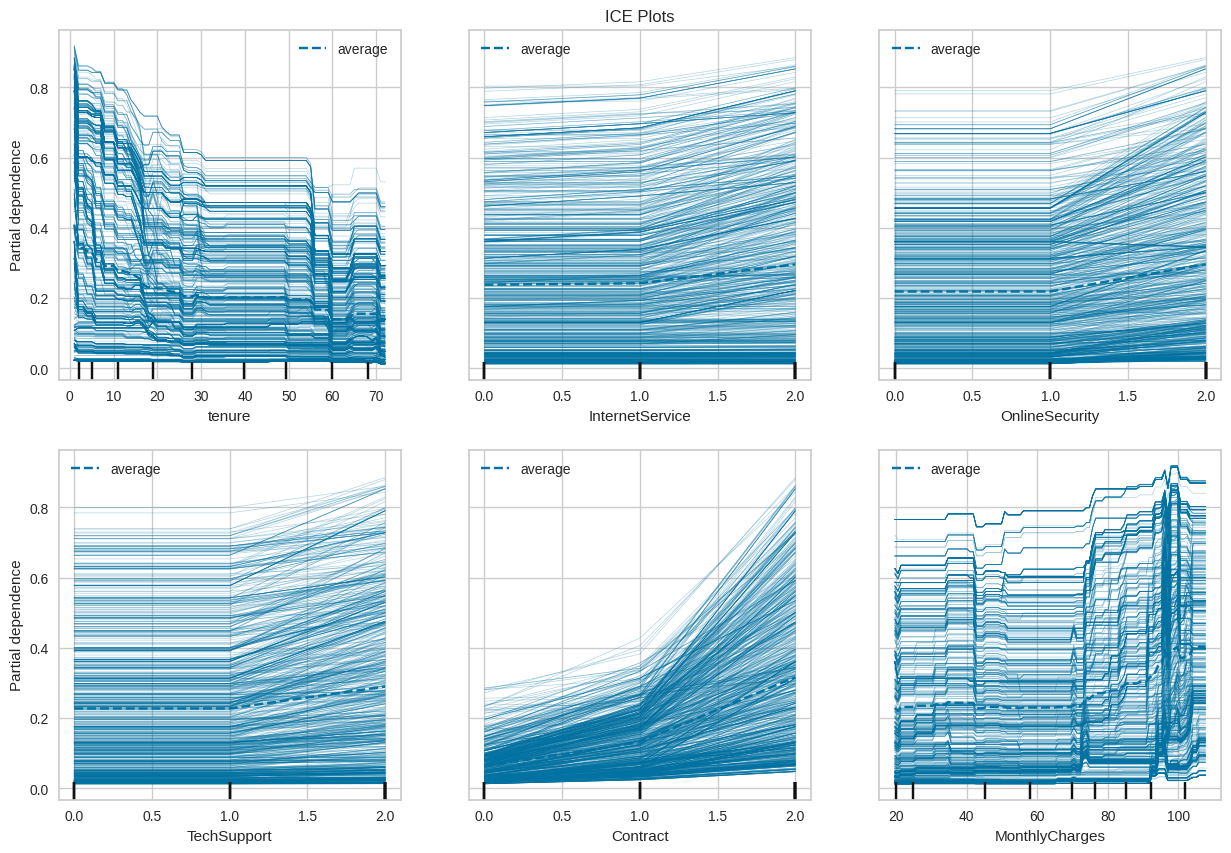

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("ICE Plots")

PartialDependenceDisplay.from_estimator(
    estimator=xgb_classifier,
    X=X_test,
    features=(0, 1, 2, 5, 6, 7), # the features to plot
    kind = "both",
    random_state=5,
    ax=ax,
)

plt.show()

### Interpretation Notes
* Disaggregated Partial Dependence Plots
* y-axis: avg. predicted probability of churn
* Interpretation:
  * Large drop in pred proba when moving from Contract 1-2 (M-to-M -> 1-yr)
  * Across all variables, you tend to see a wide predicted probability range across all values of the feature
  * Which indicates that no feature by itself is especially predictive in predicting churn
    * Contract and tenure seem to be most predictive

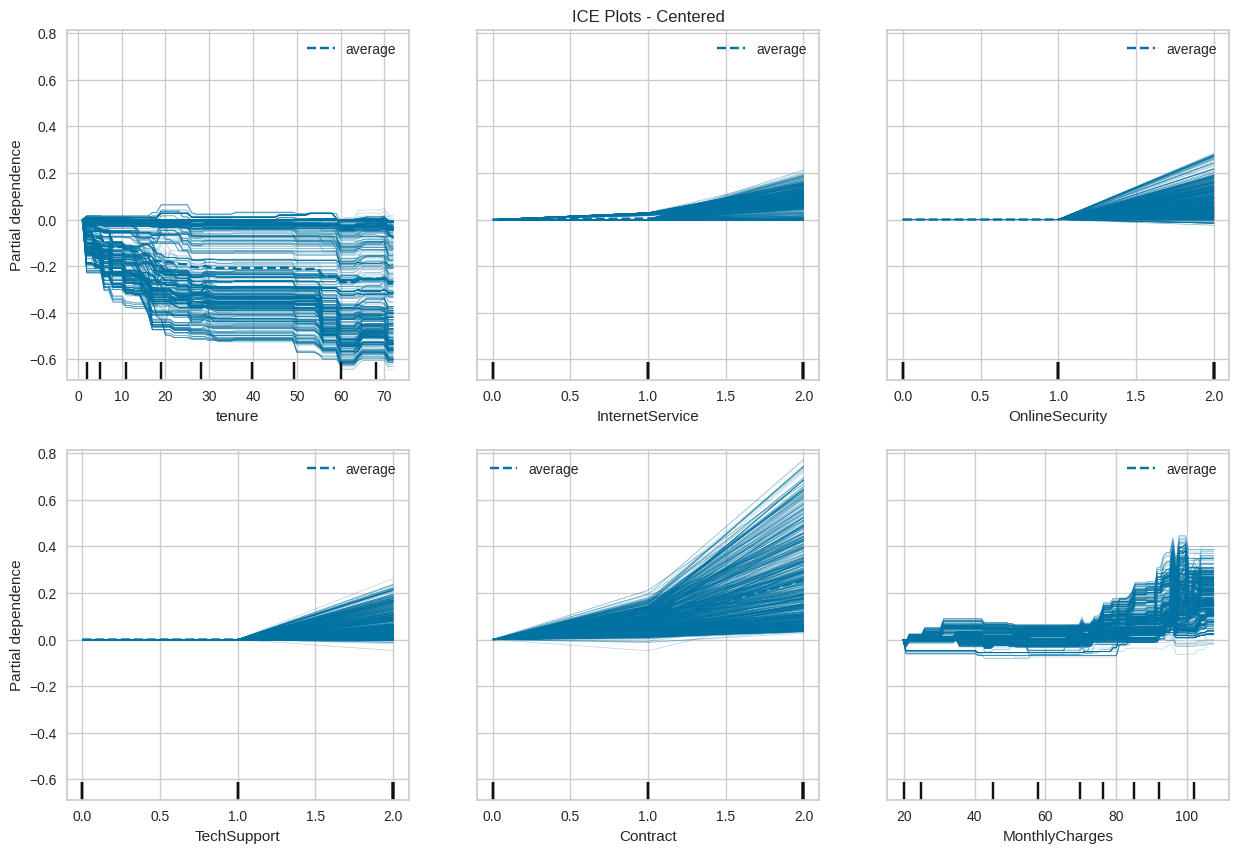

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("ICE Plots - Centered")

PartialDependenceDisplay.from_estimator(
    estimator=xgb_classifier,
    X=X_test,
    features=(0, 1, 2, 5, 6, 7), # the features to plot
    kind = "both",
    random_state=5,
    centered=True,
    ax=ax,
)

plt.show()

* Plot is centered at the mean/median predicted probability for each feature


---